# Investigating video files

In [1]:
videos_root_dir = "/Volumes/Samsung T7/surgvu24"

In [ ]:
import random
import cv2

def get_video_duration(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return 0.0
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    duration = frame_count / fps if fps else 0
    cap.release()
    return duration


def get_duration_stats(video_paths):
    durations = [get_video_duration(p) for p in video_paths]
    total = sum(durations)
    avg = total / len(durations) if durations else 0
    min_dur = min(durations) if durations else 0
    max_dur = max(durations) if durations else 0
    return {
        'total': total,
        'average': avg,
        'min': min_dur,
        'max': max_dur,
        'count': len(durations)
    }

# Dataset size

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def get_all_mp4_files(root_dir):
    mp4_files = []
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith(".mp4"):
                mp4_files.append(os.path.join(dirpath, filename))
    return mp4_files

def resize_frame(frame, short_edge=256):
    h, w = frame.shape[:2]
    if h < w:
        new_h = short_edge
        new_w = int((short_edge / h) * w)
    else:
        new_w = short_edge
        new_h = int((short_edge / w) * h)
    return cv2.resize(frame, (new_w, new_h))

def estimate_video_size(video_path, fps_target=1.0, short_edge=256):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Could not open video: {video_path}")
        return 0

    orig_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    duration_sec = frame_count / orig_fps
    target_frames = int(duration_sec * fps_target)

    success, frame = cap.read()
    cap.release()
    if not success:
        print(f"Could not read a frame from: {video_path}")
        return 0

    resized_frame = resize_frame(frame, short_edge=short_edge)
    frame_size_bytes = resized_frame.nbytes
    return target_frames * frame_size_bytes

def estimate_total_size_after_resize(root_dir, fps_target=1.0, short_edge=256):
    total_size_bytes = 0
    files = get_all_mp4_files(root_dir)
    print(f"Found {len(files)} MP4 files.")
    
    for video_path in files:
        size = estimate_video_size(video_path, fps_target, short_edge)
        total_size_bytes += size

    total_size_gb = total_size_bytes / (1024 ** 3)
    return total_size_gb

def estimate_total_frame_count(root_dir, fps_target=1.0):
    total_frames = 0
    files = get_all_mp4_files(root_dir)

    for video_path in tqdm(files):
        # print(f"Processing video: {video_path}")
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video: {video_path}")
    
        orig_fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        duration_sec = frame_count / orig_fps
        sampled_frames = int(duration_sec * fps_target)
        total_frames += sampled_frames
        cap.release()

    return total_frames

def calculate_total_original_frame_count(root_dir):
    total_frames = 0
    files = get_all_mp4_files(root_dir)

    for video_path in tqdm(files, desc="Counting original frames"):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video: {video_path}")
        
        frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        total_frames += int(frame_count)
        cap.release()

    return total_frames

# Example usage
fps = 1
short_edge = 256

est_size_gb = estimate_total_size_after_resize(root_dir=videos_root_dir, fps_target=fps, short_edge=short_edge)
print(f"\nEstimated disk space needed: {est_size_gb:.2f} GB at {fps} FPS and short edge {short_edge}px.")
total_original_frame_count= calculate_total_original_frame_count(videos_root_dir)
print(f"Total original frame count: {total_original_frame_count}")
# est_total_frames = estimate_total_frame_count(root_dir=root_dir, fps_target=fps)
# print(f"Estimated total number of frames: {est_total_frames}")


Counting original frames: 100%|██████████| 280/280 [01:12<00:00,  3.87it/s]

Total original frame count: 180962317


## Visualize frames

Frame 1000 dimensions: (1280, 720)
Size in bytes (PNG): 741638 bytes


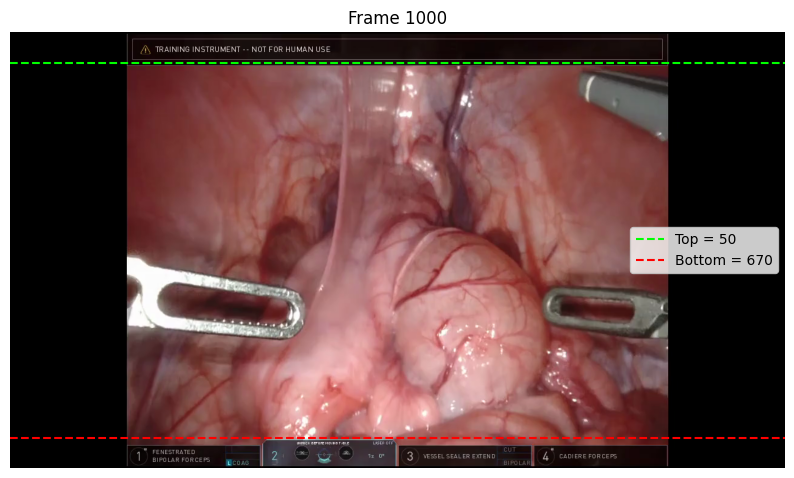

In [97]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def read_and_show_frame(video_path: str, frame_number: int = 1000, crop_top: int = 100, crop_bottom: int = 620):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return

    # Set to specific frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    ret, frame = cap.read()
    if not ret:
        print(f"Error: Could not read frame {frame_number}")
        cap.release()
        return

    # Frame dimensions
    height, width, channels = frame.shape
    dimensions = (width, height)

    # Compressed size (as PNG)
    success, encoded_img = cv2.imencode('.png', frame)
    if not success:
        print("Error: Could not encode frame.")
        cap.release()
        return

    size_in_bytes = len(encoded_img)

    print(f"Frame {frame_number} dimensions: {dimensions}")
    print(f"Size in bytes (PNG): {size_in_bytes} bytes")

    # Convert BGR to RGB for matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display frame with overlay crop bounds
    plt.figure(figsize=(10, 6))
    plt.imshow(frame_rgb)
    plt.title(f"Frame {frame_number}")
    plt.axhline(y=crop_top, color='lime', linestyle='--', label=f'Top = {crop_top}')
    plt.axhline(y=crop_bottom, color='red', linestyle='--', label=f'Bottom = {crop_bottom}')
    plt.legend()
    plt.axis('off')
    plt.show()

    cap.release()

# Example usage
example_video_path = os.path.join(videos_root_dir, "case_001/case_001_video_part_001.mp4")
read_and_show_frame(example_video_path, frame_number=1000, crop_top=50, crop_bottom=670)

## Investigate black/blank frames

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm

def is_black_frame(frame, threshold=10):
    """True if the average brightness of the frame is below the threshold."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return np.mean(gray) < threshold

def detect_black_segments(video_path, threshold=10, min_duration=1.0, frame_skip=10):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    black_segments = []

    current_segment = None
    frame_idx = 0

    with tqdm(total=frame_count // frame_skip, desc="Analyzing video") as pbar:
        while True:
            ret = cap.grab()  # skip frame by default
            if not ret:
                break

            if frame_idx % frame_skip == 0:
                ret, frame = cap.retrieve()
                if not ret:
                    break

                if is_black_frame(frame, threshold):
                    if current_segment is None:
                        current_segment = frame_idx
                else:
                    if current_segment is not None:
                        start_sec = current_segment / fps
                        end_sec = frame_idx / fps
                        if end_sec - start_sec >= min_duration:
                            black_segments.append((start_sec, end_sec))
                        current_segment = None

                pbar.update(1)

            frame_idx += 1

    # Handle final black segment
    if current_segment is not None:
        start_sec = current_segment / fps
        end_sec = frame_idx / fps
        if end_sec - start_sec >= min_duration:
            black_segments.append((start_sec, end_sec))

    cap.release()
    return black_segments

# Example usage
black_intervals= detect_black_segments(example_video_path)
for start, end in black_intervals:
    print(f"🕳️ Black sequence: from {start:.2f}s to {end:.2f}s")

## Investigating which black segments were removed

In [ ]:
FRAMES_DIR = "/Volumes/Samsung T7/surgvu24_extracted/"
LABELS_DIR = "/Users/jmachali/praca_magisterska/labels"
OUTPUT_FILE = "../data/labels.csv"

In [ ]:
import os
import re
from itertools import groupby
from operator import itemgetter

FRAME_PATTERN = re.compile(r"frame_(\d+)\.jpg")

def extract_timestamps_from_dir(path):
    timestamps = []
    for fname in os.listdir(path):
        match = FRAME_PATTERN.match(fname)
        if match:
            timestamps.append(int(match.group(1)))
    return sorted(timestamps)

def find_missing_ranges(timestamps):
    if not timestamps:
        return []

    expected = set(range(timestamps[0], timestamps[-1] + 1))
    actual = set(timestamps)
    missing = sorted(expected - actual)

    ranges = []
    for _, g in groupby(enumerate(missing), lambda x: x[0] - x[1]):
        group = list(map(itemgetter(1), g))
        start, end = group[0], group[-1]
        ranges.append((start, end))
    return ranges

for subdir in sorted(os.listdir(FRAMES_DIR)):
    full_path = os.path.join(FRAMES_DIR, subdir)
    if not os.path.isdir(full_path):
        continue

    timestamps = extract_timestamps_from_dir(full_path)
    missing_ranges = find_missing_ranges(timestamps)

    if missing_ranges:
        print(f"[!] Missing frame ranges in: {subdir}")
        for start, end in missing_ranges:
            if start == end:
                print(f"    Missing frame at second: {start}")
            else:
                print(f"    Missing from {start} to {end} seconds")

[!] Missing frame ranges in: case_000_video_part_001
    Missing from 1115 to 1682 seconds
[!] Missing frame ranges in: case_001_video_part_001
    Missing from 5507 to 6009 seconds
    Missing from 6025 to 6073 seconds
    Missing from 6116 to 6144 seconds
[!] Missing frame ranges in: case_002_video_part_001
    Missing from 313 to 2692 seconds
    Missing from 7952 to 10939 seconds
    Missing from 11173 to 11540 seconds
    Missing from 12116 to 12139 seconds
    Missing from 12727 to 12740 seconds
    Missing from 13810 to 13940 seconds
    Missing from 15096 to 15140 seconds
    Missing frame at second: 16571
    Missing frame at second: 16576
    Missing frame at second: 16585
    Missing from 16594 to 16618 seconds
    Missing frame at second: 16625
[!] Missing frame ranges in: case_002_video_part_002
    Missing frame at second: 90
    Missing from 92 to 93 seconds
    Missing from 109 to 169 seconds
[!] Missing frame ranges in: case_003_video_part_001
    Missing from 562 to 2

# Labeling

## Finding missing labels

In [110]:
import os
import pandas as pd

verified_task_names= set(['Suturing', 'Rectal artery/vein', 'Uterine horn', 'Skills application', 'Suspensory ligaments', 'Retraction and collision avoidance', 'Range of motion'])

for case_dir in sorted(os.listdir(LABELS_DIR)):
    case_path = os.path.join(LABELS_DIR, case_dir)
    tasks_csv = os.path.join(case_path, "tasks.csv")

    if not os.path.exists(tasks_csv):
        print(f"[!] {tasks_csv} does not exist.")

    try:
        df = pd.read_csv(tasks_csv)
    except Exception as e:
        print(f"[!] Failed to read {tasks_csv}: {e}")
        continue

    for i, row in df.iterrows():
        start_part = int(row["start_part"])
        stop_part = int(row["stop_part"])
        task_name = row["groundtruth_taskname"]
        if not {start_part, stop_part}.issubset({1, 2}):
            raise ValueError(
                f"[!] Task '{task_name}' in {case_dir} spans more than 2 parts: {start_part} → {stop_part}"
            )
        if start_part > stop_part:
            raise ValueError(
                f"[!] Task '{task_name}' in {case_dir} has invalid part order: {start_part} → {stop_part}"
            )
        if task_name not in verified_task_names:
            print(f"Invalid task name for {case_dir}: {task_name} in file {tasks_csv} in row {i}")

print("[✓] All tasks verified: no task spans more than 2 parts.")

[!] /Users/jmachali/praca_magisterska/labels/.DS_Store/tasks.csv does not exist.
[!] Failed to read /Users/jmachali/praca_magisterska/labels/.DS_Store/tasks.csv: [Errno 20] Not a directory: '/Users/jmachali/praca_magisterska/labels/.DS_Store/tasks.csv'
Invalid task name for case_021: nan in file /Users/jmachali/praca_magisterska/labels/case_021/tasks.csv in row 10
Invalid task name for case_024: nan in file /Users/jmachali/praca_magisterska/labels/case_024/tasks.csv in row 8
Invalid task name for case_033: nan in file /Users/jmachali/praca_magisterska/labels/case_033/tasks.csv in row 4
Invalid task name for case_033: nan in file /Users/jmachali/praca_magisterska/labels/case_033/tasks.csv in row 6
Invalid task name for case_074: nan in file /Users/jmachali/praca_magisterska/labels/case_074/tasks.csv in row 9
Invalid task name for case_074: nan in file /Users/jmachali/praca_magisterska/labels/case_074/tasks.csv in row 11
Invalid task name for case_074: nan in file /Users/jmachali/praca_m

## Labeling frames

In [ ]:

import os
import pandas as pd
import re
from tqdm import tqdm

# assuming format after extracting frames from videos with ffmpeg
def parse_case_and_part(dir_name):
    match = re.match(r"(case_\d+)_video_part_(\d+)", dir_name)
    if match:
        case_id = match.group(1)
        part_id = int(match.group(2))  # e.g. 1
        return case_id, part_id
    return None, None

def get_frame_timestamp(frame_name):
    match = re.match(r"frame_(\d+)\.jpg", frame_name)
    if match:
        return int(match.group(1))  # at 1 FPS, this is the second timestamp
    return None


UNLABELED = "unlabeled"

data = []

for part_dir_name in tqdm(sorted(os.listdir(FRAMES_DIR))):
    if part_dir_name.startswith("."):
        continue
    
    full_part_dir = os.path.join(FRAMES_DIR, part_dir_name)
    if not os.path.isdir(full_part_dir):
        raise ValueError(f"[!] {full_part_dir} is not a directory.")

    case_id, part_id = parse_case_and_part(part_dir_name)
    if case_id is None:
        print(f"[!] Skipping directory (unrecognized format): {part_dir_name}")
        continue

    case_label_path = os.path.join(LABELS_DIR, case_id, "tasks.csv")
    if not os.path.exists(case_label_path):
        print(f"[!] No labels found for {case_id}, skipping.")
        continue

    tasks_df = pd.read_csv(case_label_path)

    for frame_file in sorted(os.listdir(full_part_dir)):
        frame_path = os.path.join(full_part_dir, frame_file)
        timestamp = get_frame_timestamp(frame_file)
        if timestamp is None:
            print(f"[!] Skipping file (unrecognized format): {frame_file}")
            continue

        frame_label = UNLABELED

        for _, row in tasks_df.iterrows():
            task_name = row["groundtruth_taskname"]
            if pd.isna(task_name) or str(task_name).strip() == "":
                task_name = UNLABELED
            start_part = int(row["start_part"])
            stop_part = int(row["stop_part"])
            start_time = row["start_time"]
            stop_time = row["stop_time"]
            
            if abs(stop_part - start_part) > 1:
                raise ValueError(f"[!] Task '{task_name}' in {case_id} spans more than 2 parts: {start_part} → {stop_part}")
            
            if part_id == start_part and start_part != stop_part:
                # Task starts in this part and continues to the next
                if start_time <= timestamp:
                    frame_label = task_name
                    break
            elif part_id == stop_part and start_part != stop_part:
                # Task ends in this part, having started earlier
                if timestamp < stop_time:
                    frame_label = task_name
                    break
            elif start_part == stop_part == part_id:
                # Task is fully contained in this part
                if start_time <= timestamp < stop_time:
                    frame_label = task_name
                    break

        if frame_label is None:
            print(f"[!] No label found for frame {frame_file} in {case_id}, part {part_id}")
        
        data.append({
            "frame_path": frame_path,
            "case": case_id,
            "part": part_id,
            "frame_time": timestamp,
            "label": frame_label
        })

df_out = pd.DataFrame(data)

  1%|          | 2/281 [00:00<00:14, 19.59it/s]

[!] Skipping file (unrecognized format): .DS_Store
[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


  2%|▏         | 5/281 [00:04<04:29,  1.02it/s]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


  2%|▏         | 7/281 [00:06<04:26,  1.03it/s]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


  3%|▎         | 9/281 [00:09<05:27,  1.20s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


  4%|▎         | 10/281 [00:11<06:21,  1.41s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


  4%|▍         | 11/281 [00:13<06:09,  1.37s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


  5%|▍         | 14/281 [00:16<05:38,  1.27s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


  5%|▌         | 15/281 [00:20<07:46,  1.75s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


  6%|▌         | 16/281 [00:22<08:14,  1.87s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


  6%|▌         | 17/281 [00:23<07:41,  1.75s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


  6%|▋         | 18/281 [00:26<09:15,  2.11s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


  7%|▋         | 19/281 [00:27<08:02,  1.84s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


  7%|▋         | 21/281 [00:29<05:04,  1.17s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


  8%|▊         | 23/281 [00:34<07:44,  1.80s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


  9%|▉         | 25/281 [00:39<08:36,  2.02s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


  9%|▉         | 26/281 [00:44<12:55,  3.04s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 10%|▉         | 27/281 [00:46<10:37,  2.51s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 10%|▉         | 28/281 [00:47<08:31,  2.02s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 11%|█         | 30/281 [00:50<07:20,  1.76s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 11%|█▏        | 32/281 [00:51<05:03,  1.22s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 12%|█▏        | 33/281 [00:54<06:46,  1.64s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 12%|█▏        | 35/281 [00:55<04:36,  1.12s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 13%|█▎        | 37/281 [00:58<04:18,  1.06s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 14%|█▍        | 39/281 [01:01<05:13,  1.30s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 15%|█▍        | 41/281 [01:04<04:53,  1.22s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 15%|█▍        | 42/281 [01:05<05:02,  1.27s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 15%|█▌        | 43/281 [01:08<06:32,  1.65s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 16%|█▌        | 44/281 [01:09<05:47,  1.47s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 16%|█▋        | 46/281 [01:12<05:40,  1.45s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 17%|█▋        | 47/281 [01:13<05:09,  1.32s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 17%|█▋        | 48/281 [01:14<04:28,  1.15s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 17%|█▋        | 49/281 [01:16<05:24,  1.40s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 18%|█▊        | 50/281 [01:16<04:34,  1.19s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 18%|█▊        | 51/281 [01:19<05:44,  1.50s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 19%|█▉        | 53/281 [01:20<04:25,  1.17s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 19%|█▉        | 54/281 [01:22<04:36,  1.22s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 20%|██        | 57/281 [01:25<04:00,  1.07s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 21%|██        | 58/281 [01:28<05:58,  1.61s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 21%|██        | 59/281 [01:29<05:17,  1.43s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 21%|██▏       | 60/281 [01:34<08:41,  2.36s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 22%|██▏       | 61/281 [01:35<07:39,  2.09s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 22%|██▏       | 62/281 [01:37<06:46,  1.86s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 22%|██▏       | 63/281 [01:38<06:34,  1.81s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 23%|██▎       | 64/281 [01:43<09:36,  2.66s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 23%|██▎       | 65/281 [01:44<08:19,  2.31s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 24%|██▍       | 67/281 [01:48<06:41,  1.88s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 25%|██▍       | 69/281 [01:51<06:23,  1.81s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 25%|██▌       | 71/281 [01:53<04:48,  1.37s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 26%|██▌       | 73/281 [01:58<05:47,  1.67s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 26%|██▋       | 74/281 [02:01<07:50,  2.27s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 27%|██▋       | 75/281 [02:03<07:18,  2.13s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 27%|██▋       | 77/281 [02:06<05:41,  1.68s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 28%|██▊       | 78/281 [02:09<06:50,  2.02s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 28%|██▊       | 79/281 [02:10<05:33,  1.65s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 28%|██▊       | 80/281 [02:12<05:58,  1.78s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 29%|██▉       | 82/281 [02:15<05:38,  1.70s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 30%|██▉       | 84/281 [02:19<05:28,  1.67s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 31%|███       | 86/281 [02:22<05:07,  1.58s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 31%|███▏      | 88/281 [02:26<05:15,  1.63s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 32%|███▏      | 90/281 [02:28<04:01,  1.26s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 32%|███▏      | 91/281 [02:30<04:38,  1.46s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 33%|███▎      | 93/281 [02:31<02:55,  1.07it/s]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 33%|███▎      | 94/281 [02:33<03:43,  1.19s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 34%|███▍      | 95/281 [02:34<03:26,  1.11s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 34%|███▍      | 96/281 [02:37<05:48,  1.88s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 35%|███▍      | 97/281 [02:38<04:51,  1.59s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 35%|███▍      | 98/281 [02:43<07:25,  2.43s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 35%|███▌      | 99/281 [02:45<07:08,  2.36s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 36%|███▌      | 100/281 [02:49<08:14,  2.73s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 36%|███▌      | 101/281 [02:50<07:12,  2.40s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 36%|███▋      | 102/281 [02:52<06:44,  2.26s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 37%|███▋      | 103/281 [02:53<05:19,  1.80s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 37%|███▋      | 105/281 [02:55<03:52,  1.32s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 38%|███▊      | 106/281 [02:58<05:25,  1.86s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 38%|███▊      | 108/281 [03:00<04:18,  1.49s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 39%|███▉      | 110/281 [03:04<04:39,  1.63s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 40%|███▉      | 111/281 [03:05<03:42,  1.31s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 40%|████      | 113/281 [03:10<05:02,  1.80s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 41%|████      | 115/281 [03:12<03:54,  1.42s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 42%|████▏     | 117/281 [03:15<03:54,  1.43s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 42%|████▏     | 119/281 [03:18<03:37,  1.34s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 43%|████▎     | 120/281 [03:22<05:07,  1.91s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 43%|████▎     | 121/281 [03:23<04:20,  1.63s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 43%|████▎     | 122/281 [03:25<04:55,  1.86s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 44%|████▍     | 123/281 [03:26<04:29,  1.71s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 44%|████▍     | 125/281 [03:29<03:31,  1.35s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 45%|████▍     | 126/281 [03:30<03:40,  1.42s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 46%|████▌     | 128/281 [03:31<02:17,  1.11it/s]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 46%|████▌     | 129/281 [03:33<03:14,  1.28s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 46%|████▋     | 130/281 [03:34<03:10,  1.26s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 47%|████▋     | 132/281 [03:38<03:39,  1.48s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 47%|████▋     | 133/281 [03:42<05:11,  2.11s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 48%|████▊     | 134/281 [03:43<04:43,  1.93s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 48%|████▊     | 136/281 [03:46<03:40,  1.52s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 49%|████▉     | 138/281 [03:49<03:19,  1.39s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 49%|████▉     | 139/281 [03:50<03:03,  1.29s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 50%|████▉     | 140/281 [03:50<02:34,  1.09s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 50%|█████     | 141/281 [03:52<03:12,  1.38s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 51%|█████     | 143/281 [03:56<03:27,  1.51s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 52%|█████▏    | 145/281 [03:59<03:13,  1.43s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 52%|█████▏    | 146/281 [04:01<03:21,  1.49s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 53%|█████▎    | 148/281 [04:04<03:33,  1.60s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 53%|█████▎    | 150/281 [04:05<02:06,  1.03it/s]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 54%|█████▍    | 152/281 [04:09<02:51,  1.33s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 54%|█████▍    | 153/281 [04:10<02:58,  1.40s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 55%|█████▍    | 154/281 [04:12<02:58,  1.41s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 56%|█████▌    | 156/281 [04:14<02:25,  1.16s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 56%|█████▌    | 158/281 [04:16<02:13,  1.08s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 57%|█████▋    | 159/281 [04:17<02:24,  1.18s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 57%|█████▋    | 160/281 [04:18<02:00,  1.01it/s]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 57%|█████▋    | 161/281 [04:21<03:11,  1.60s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 58%|█████▊    | 162/281 [04:22<02:52,  1.45s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 58%|█████▊    | 164/281 [04:24<02:16,  1.17s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 59%|█████▉    | 166/281 [04:28<02:35,  1.35s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 59%|█████▉    | 167/281 [04:30<02:52,  1.51s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 60%|█████▉    | 168/281 [04:30<02:24,  1.27s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 60%|██████    | 169/281 [04:34<03:29,  1.87s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 60%|██████    | 170/281 [04:34<02:51,  1.54s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 61%|██████    | 172/281 [04:38<02:44,  1.51s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 62%|██████▏   | 173/281 [04:41<03:23,  1.89s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 62%|██████▏   | 174/281 [04:42<02:49,  1.58s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 63%|██████▎   | 176/281 [04:45<02:43,  1.56s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 63%|██████▎   | 177/281 [04:47<02:59,  1.73s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 63%|██████▎   | 178/281 [04:49<03:01,  1.77s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 64%|██████▍   | 180/281 [04:52<02:45,  1.64s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 64%|██████▍   | 181/281 [04:54<02:58,  1.79s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 65%|██████▍   | 182/281 [04:58<03:37,  2.20s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 65%|██████▌   | 183/281 [04:59<03:05,  1.90s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 66%|██████▌   | 185/281 [05:02<02:42,  1.69s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 66%|██████▌   | 186/281 [05:04<02:56,  1.86s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 67%|██████▋   | 187/281 [05:05<02:20,  1.49s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 67%|██████▋   | 188/281 [05:09<03:15,  2.10s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 67%|██████▋   | 189/281 [05:10<02:43,  1.78s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 68%|██████▊   | 191/281 [05:14<02:36,  1.74s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 68%|██████▊   | 192/281 [05:14<02:07,  1.44s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 69%|██████▉   | 195/281 [05:18<01:25,  1.01it/s]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 70%|███████   | 197/281 [05:20<01:34,  1.13s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 71%|███████   | 199/281 [05:23<01:43,  1.27s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 72%|███████▏  | 201/281 [05:28<02:07,  1.59s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 72%|███████▏  | 202/281 [05:30<02:20,  1.78s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 72%|███████▏  | 203/281 [05:32<02:14,  1.73s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 73%|███████▎  | 205/281 [05:32<01:20,  1.05s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 73%|███████▎  | 206/281 [05:37<02:26,  1.96s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 74%|███████▎  | 207/281 [05:38<02:15,  1.83s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 74%|███████▍  | 209/281 [05:41<01:48,  1.51s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 75%|███████▍  | 210/281 [05:44<02:14,  1.90s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 75%|███████▌  | 211/281 [05:44<01:47,  1.54s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 76%|███████▌  | 213/281 [05:47<01:30,  1.33s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 77%|███████▋  | 215/281 [05:51<01:40,  1.52s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 77%|███████▋  | 216/281 [05:53<01:52,  1.73s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 77%|███████▋  | 217/281 [05:54<01:38,  1.54s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 78%|███████▊  | 218/281 [05:56<01:49,  1.73s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 78%|███████▊  | 219/281 [05:57<01:25,  1.38s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 79%|███████▊  | 221/281 [06:01<01:31,  1.53s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 79%|███████▉  | 223/281 [06:03<01:16,  1.32s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 80%|████████  | 225/281 [06:04<00:49,  1.12it/s]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 80%|████████  | 226/281 [06:07<01:25,  1.56s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 81%|████████  | 227/281 [06:08<01:11,  1.32s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 81%|████████  | 228/281 [06:11<01:29,  1.69s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 81%|████████▏ | 229/281 [06:14<01:57,  2.26s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 82%|████████▏ | 230/281 [06:17<02:00,  2.35s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 83%|████████▎ | 232/281 [06:20<01:26,  1.78s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 83%|████████▎ | 233/281 [06:24<02:00,  2.50s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 84%|████████▍ | 236/281 [06:26<01:04,  1.44s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 84%|████████▍ | 237/281 [06:29<01:23,  1.90s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 85%|████████▍ | 238/281 [06:30<01:11,  1.66s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 85%|████████▌ | 240/281 [06:35<01:12,  1.77s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 86%|████████▌ | 242/281 [06:39<01:11,  1.84s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 86%|████████▋ | 243/281 [06:41<01:18,  2.07s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 87%|████████▋ | 244/281 [06:42<01:04,  1.75s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 88%|████████▊ | 246/281 [06:47<01:08,  1.95s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 88%|████████▊ | 248/281 [06:51<00:58,  1.77s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 89%|████████▉ | 250/281 [06:54<00:51,  1.65s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 89%|████████▉ | 251/281 [06:56<00:52,  1.74s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 90%|█████████ | 253/281 [07:00<00:49,  1.76s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 90%|█████████ | 254/281 [07:01<00:43,  1.60s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 91%|█████████ | 255/281 [07:06<01:07,  2.59s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 91%|█████████ | 256/281 [07:08<00:58,  2.32s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 91%|█████████▏| 257/281 [07:11<00:59,  2.47s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 92%|█████████▏| 258/281 [07:12<00:52,  2.26s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 92%|█████████▏| 259/281 [07:16<00:56,  2.57s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 93%|█████████▎| 260/281 [07:18<00:52,  2.49s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 93%|█████████▎| 262/281 [07:20<00:34,  1.80s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 94%|█████████▎| 263/281 [07:24<00:44,  2.45s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 94%|█████████▍| 264/281 [07:25<00:30,  1.82s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 95%|█████████▍| 266/281 [07:29<00:27,  1.85s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 95%|█████████▌| 267/281 [07:29<00:21,  1.53s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 96%|█████████▌| 269/281 [07:32<00:17,  1.46s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 96%|█████████▋| 271/281 [07:38<00:19,  1.97s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 97%|█████████▋| 272/281 [07:39<00:14,  1.58s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log
[!] Skipping file (unrecognized format): ffmpeg_output.log


 98%|█████████▊| 274/281 [07:41<00:10,  1.47s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 98%|█████████▊| 275/281 [07:42<00:07,  1.30s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 98%|█████████▊| 276/281 [07:45<00:07,  1.59s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 99%|█████████▊| 277/281 [07:46<00:06,  1.57s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 99%|█████████▉| 278/281 [07:49<00:06,  2.06s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


 99%|█████████▉| 279/281 [07:51<00:03,  1.90s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


100%|██████████| 281/281 [07:54<00:00,  1.67s/it]

[!] Skipping file (unrecognized format): ffmpeg_output.log


100%|██████████| 281/281 [07:54<00:00,  1.69s/it]


[✓] Saved labeled frames to ../data/labels.csv


### Change frame paths to relative paths

In [ ]:
df_out['frame_path'] = df_out['frame_path'].apply(lambda x: os.path.relpath(x, start=FRAMES_DIR))


In [154]:
df_out.to_csv(OUTPUT_FILE, index=False)
print(f"[✓] Saved labeled frames to {OUTPUT_FILE}")

[✓] Saved labeled frames to ../data/labels.csv


## Labeled data stats


=== Dataset overview ===
                                frame_path      case  part  frame_time  \
0  case_000_video_part_001/frame_00001.jpg  case_000     1           1   
1  case_000_video_part_001/frame_00002.jpg  case_000     1           2   
2  case_000_video_part_001/frame_00003.jpg  case_000     1           3   
3  case_000_video_part_001/frame_00004.jpg  case_000     1           4   
4  case_000_video_part_001/frame_00005.jpg  case_000     1           5   

       label  split  
0  unlabeled  train  
1  unlabeled  train  
2  unlabeled  train  
3  unlabeled  train  
4  unlabeled  train  

Label distribution:
label
unlabeled                             1583230
Suturing                               270438
Uterine horn                           157047
Rectal artery/vein                     134514
Suspensory ligaments                    86864
Skills application                      55093
Retraction and collision avoidance      21189
Range of motion                         19459
Na

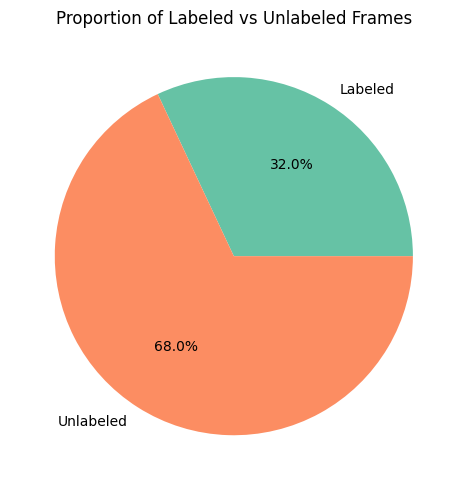

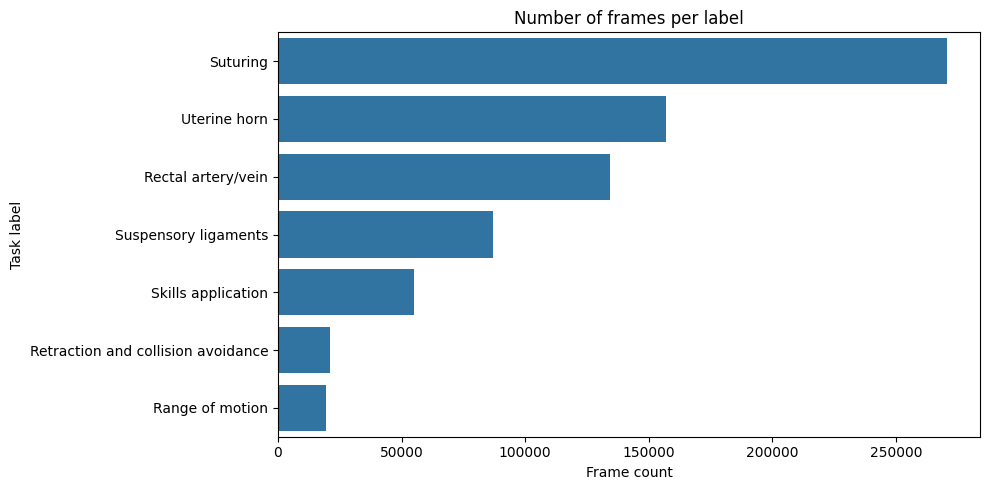

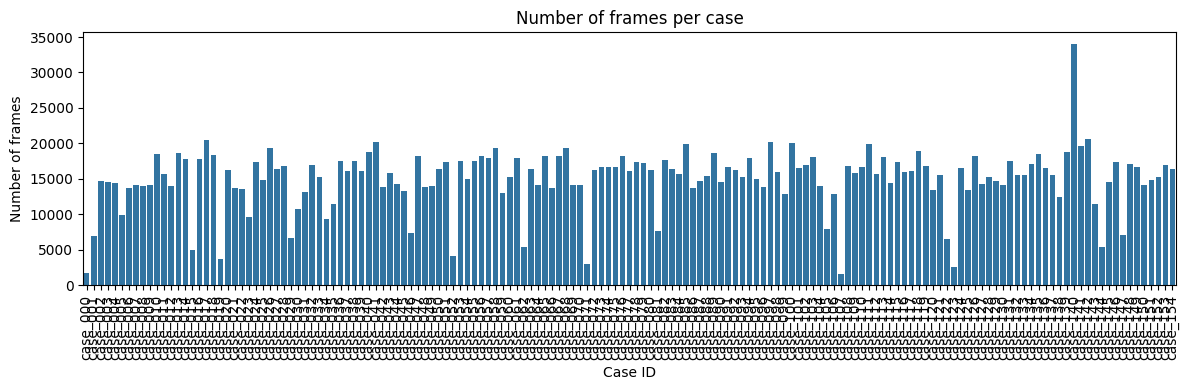

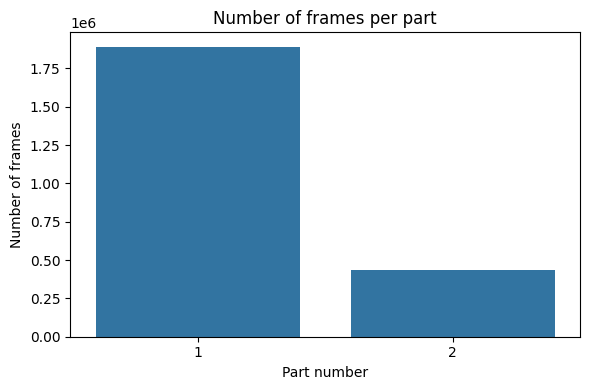

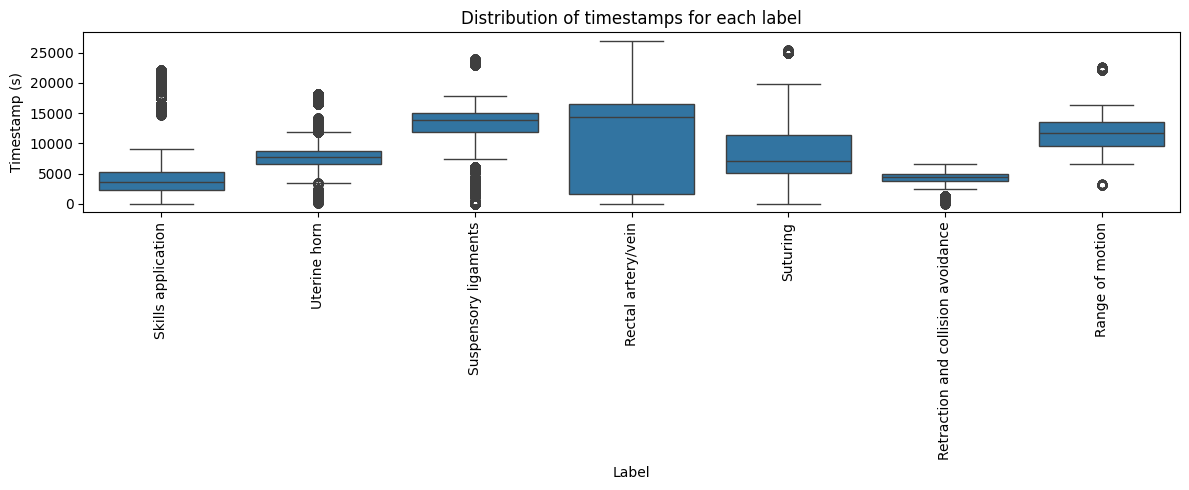

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
LABELS_CSV_PATH = "../data/labels.csv"

# Load data
df= pd.read_csv(LABELS_CSV_PATH)

# === 1. Basic info ===
print("\n=== Dataset overview ===")
print(df.head())
print("\nLabel distribution:")
print(df['label'].value_counts())

# === 2. Number of labeled vs. unlabeled frames ===
label_counts = df['label'].value_counts()
num_labeled = df[df['label'] != 'unlabeled'].shape[0]
num_unlabeled = df[df['label'] == 'unlabeled'].shape[0]
total = len(df)

print(f"\nTotal frames: {total}")
print(f"Labeled frames: {num_labeled} ({num_labeled / total:.2%})")
print(f"Unlabeled frames: {num_unlabeled} ({num_unlabeled / total:.2%})")

# === 3. Pie chart for labeled vs. unlabeled ===
plt.figure(figsize=(5, 5))
plt.pie(
    [num_labeled, num_unlabeled],
    labels=["Labeled", "Unlabeled"],
    autopct="%1.1f%%",
    colors=["#66c2a5", "#fc8d62"]
)
plt.title("Proportion of Labeled vs Unlabeled Frames")
plt.tight_layout()
plt.show()

# === 4. Frames per label (excluding "unlabeled") ===
df_labeled = df[df['label'] != 'unlabeled']
label_distribution = df_labeled['label'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=label_distribution.values, y=label_distribution.index)
plt.title("Number of frames per label")
plt.xlabel("Frame count")
plt.ylabel("Task label")
plt.tight_layout()
plt.show()

# === 5. Frames per case ===
case_distribution = df['case'].value_counts().sort_index()

plt.figure(figsize=(12, 4))
sns.barplot(x=case_distribution.index, y=case_distribution.values)
plt.title("Number of frames per case")
plt.xlabel("Case ID")
plt.ylabel("Number of frames")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# === 6. Frames per part ===
part_distribution = df['part'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
sns.barplot(x=part_distribution.index, y=part_distribution.values)
plt.title("Number of frames per part")
plt.xlabel("Part number")
plt.ylabel("Number of frames")
plt.tight_layout()
plt.show()

# === 7. Frame timestamp distribution per label ===
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_labeled, x='label', y='frame_time')
plt.xticks(rotation=90)
plt.title("Distribution of timestamps for each label")
plt.xlabel("Label")
plt.ylabel("Timestamp (s)")
plt.tight_layout()
plt.show()

In [129]:
    
def compare_number_of_frames_to_video_duration(videos_root_dir, case_distribution):
    for case,value in case_distribution.items():
        print(f"Case {case}: {value} frames")
        case_dir = os.path.join(videos_root_dir, case)
        if not os.path.exists(case_dir):
            print(f"[!] Case directory does not exist: {case_dir}")
            continue

        video_files = [f for f in os.listdir(case_dir) if f.endswith('.mp4')]
        if not video_files:
            print(f"[!] No video files found in {case_dir}")
            continue

        total_duration = 0.0
        for video_file in video_files:
            video_path = os.path.join(case_dir, video_file)
            duration = get_video_duration(video_path)
            total_duration += duration
            # print(f"  Video: {video_file}, Duration: {duration:.2f} seconds")
        print(f"  Total duration: {total_duration:.2f} seconds ({total_duration / 60:.2f} minutes)")
    

In [131]:
compare_number_of_frames_to_video_duration(videos_root_dir, case_distribution.nsmallest(10, keep='all'))


Case case_107: 1599 frames
  Total duration: 1599.33 seconds (26.66 minutes)
Case case_000: 1792 frames
  Total duration: 2518.88 seconds (41.98 minutes)
Case case_123: 2634 frames
  Total duration: 2633.55 seconds (43.89 minutes)
Case case_071: 2987 frames
  Total duration: 3016.03 seconds (50.27 minutes)
Case case_019: 3726 frames
  Total duration: 4121.98 seconds (68.70 minutes)
Case case_052: 4106 frames
  Total duration: 4134.82 seconds (68.91 minutes)
Case case_015: 4905 frames
  Total duration: 5261.02 seconds (87.68 minutes)
Case case_062: 5338 frames
  Total duration: 5634.72 seconds (93.91 minutes)
Case case_144: 5431 frames
  Total duration: 7567.50 seconds (126.12 minutes)
Case case_122: 6579 frames
  Total duration: 8382.45 seconds (139.71 minutes)


In [ ]:
compare_number_of_frames_to_video_duration(videos_root_dir, case_distribution.nlargest(10, keep='all'))

case
case_140    33966
case_142    20603
case_017    20480
case_041    20258
case_097    20162
case_100    19992
case_085    19915
case_111    19915
case_141    19666
case_026    19406
case_058    19406
Name: count, dtype: int64

Values are different due to the fact that some frames were removed as being black frames

In [ ]:
import pandas as pd

case_summary = df.groupby("case")["label"].value_counts().unstack(fill_value=0)
case_summary["total"] = case_summary.sum(axis=1)
case_summary = case_summary.sort_values("total", ascending=False)
case_summary

label     Range of motion  Rectal artery/vein  \
case                                            
case_140              449                1111   
case_142              257                2321   
case_017                0                1496   
case_041              298                2448   
case_097                0                 893   
...                   ...                 ...   
case_019                0                   0   
case_071                0                   0   
case_123                0                 121   
case_000                0                   0   
case_107                0                   0   

label     Retraction and collision avoidance  Skills application  \
case                                                               
case_140                                   0                   0   
case_142                                 691                   0   
case_017                                   0                   0   
case_041                                 159                   0   
case_097                                 665                   0   
...                                      ...                 ...   
case_019                                   0                   0   
case_071                                   0                 590   
case_123                                   0                   0   
case_000                                   0                 564   
case_107                                   0                   0   

label     Suspensory ligaments  Suturing  Uterine horn  unlabeled  total  
case                                                                      
case_140                  1040      2198          1736      27001  33535  
case_142                  1545      2740          1590      11459  20603  
case_017                     0       486             0      18498  20480  
case_041                  1240      2533          1765      11815  20258  
case_097                   527      2412          1526      14139  20162  
...                        ...       ...           ...        ...    ...  
case_019                   190       301           404       2831   3726  
case_071                     0         0             0       2397   2987  
case_123                   165       339           305       1704   2634  
case_000                     0         0             0       1228   1792  
case_107                     0       388             0       1211   1599  

[155 rows x 9 columns]

# Spliting the dataset into train, test and validation sets

In [18]:
import numpy as np
import random
def prepare_basic_splits(df: pd.DataFrame, test_frac=0.1, val_frac=0.1, random_seed=42):
    df = df.copy()
    random.seed(random_seed)
    np.random.seed(random_seed)

    # Get labeled and unlabeled
    labeled_df = df[df['label'] != 'unlabeled']
    unlabeled_df = df[df['label'] == 'unlabeled']

    # Group by full case name (case + part to make it more granular if needed)
    labeled_cases = labeled_df['case'].unique()

    # Determine number of test and validation cases
    n_test = max(1, int(len(labeled_cases) * test_frac))
    n_val = max(1, int(len(labeled_cases) * val_frac))

    test_cases = labeled_cases[:n_test]
    val_cases = labeled_cases[n_test:n_test + n_val]
    train_cases = labeled_cases[n_test + n_val:]

    # Create splits
    df['split'] = 'unassigned'

    # Assign test split
    df.loc[df['case'].isin(test_cases), 'split'] = 'test'
    # Assign val split
    df.loc[df['case'].isin(val_cases), 'split'] = 'val'
    # Assign train split
    df.loc[df['case'].isin(train_cases), 'split'] = 'train'

    # Ensure that no frame from test/val cases is included in train (even if unlabeled)
    excluded_cases = set(test_cases).union(set(val_cases))
    df.loc[df['case'].isin(excluded_cases) & (df['split'] == 'train'), 'split'] = 'excluded'

    # Summary
    split_summary = df['split'].value_counts()
    label_distribution = df[df['label'].notna() & (df['label'] != 'unlabeled')].groupby('split')['label'].value_counts(normalize=True)

    return df, {
        "split_summary": split_summary.to_dict(),
        "label_distribution_labeled_only": label_distribution.unstack().fillna(0).to_dict()
    }


In [7]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from typing import List, Tuple
from tqdm import tqdm

def evaluate_label_balance(df: pd.DataFrame, split_cases: dict) -> float:
    """Compute the average standard deviation of label distributions across splits."""
    label_counts = defaultdict(Counter)

    for split, cases in split_cases.items():
        subset = df[(df['case'].isin(cases)) & (df['label'].notna()) & (df['label'] != 'unlabeled')]
        subset['label'] = subset['label'].astype(str)
        label_counts[split].update(subset['label'])

    # Get all labels across splits
    labels = sorted(set().union(*[counts.keys() for counts in label_counts.values()]))
    if not labels:
        return float('inf')  # prevent division by zero

    matrix = []
    for split in split_cases.keys():
        row = [label_counts[split].get(label, 0) for label in labels]
        matrix.append(row)

    matrix = np.array(matrix, dtype=np.float32)
    proportions = matrix / (matrix.sum(axis=1, keepdims=True) + 1e-6)  # prevent div0
    stds = np.std(proportions, axis=0)

    return float(np.mean(stds))  # Lower = more balanced

def find_best_case_split(
    df: pd.DataFrame,
    all_cases: List[str],
    frac: float,
    split_a: str,
    split_b: str,
    n_trials: int = 1000,
    seed: int = 42
) -> Tuple[List[str], List[str]]:
    np.random.seed(seed)
    best_score = float('inf')
    best_split = None

    for _ in tqdm(range(n_trials), desc=f"Searching best {split_a}/{split_b} split"):
        np.random.shuffle(all_cases)
        n_b = int(len(all_cases) * frac)
        if n_b < 1 or n_b >= len(all_cases):
            continue

        b_cases = all_cases[:n_b]
        a_cases = all_cases[n_b:]

        score = evaluate_label_balance(df, {split_a: a_cases, split_b: b_cases})
        if score < best_score:
            best_score = score
            best_split = (a_cases, b_cases)

    if best_split is None:
        raise ValueError(f"Could not find a valid {split_a}/{split_b} split from {len(all_cases)} cases (frac={frac})")

    return best_split

def prepare_balanced_split(df: pd.DataFrame, test_frac=0.1, val_frac=0.1, n_trials=1000, seed=42):
    df = df.copy()
    df['case'] = df['case'].astype(str)

    all_cases = df[df['label'].notna() & (df['label'] != 'unlabeled')]['case'].unique().tolist()
    if len(all_cases) < 3:
        raise ValueError(f"Too few labeled cases ({len(all_cases)}) to perform a valid split.")

    trainval_cases, test_cases = find_best_case_split(
        df, all_cases, test_frac,
        split_a="trainval", split_b="test",
        seed=seed, n_trials=n_trials
    )
    print(f"[✓] Found best trainval/test split: {len(trainval_cases)} trainval cases, {len(test_cases)} test cases")

    val_frac_adjusted = val_frac / (1 - test_frac)
    train_cases, val_cases = find_best_case_split(
        df, trainval_cases, val_frac_adjusted,
        split_a="train", split_b="val",
        seed=seed, n_trials=n_trials
    )
    print(f"[✓] Found best train/val split: {len(train_cases)} train cases, {len(val_cases)} val cases")

    # Assign splits
    df['split'] = 'unassigned'
    df.loc[df['case'].isin(train_cases), 'split'] = 'train'
    df.loc[df['case'].isin(val_cases), 'split'] = 'val'
    df.loc[df['case'].isin(test_cases), 'split'] = 'test'

    # Remove any unlabeled frames from excluded cases
    excluded_cases = set(val_cases + test_cases)
    df.loc[df['case'].isin(excluded_cases) & (df['split'] == 'train'), 'split'] = 'excluded'

    # Summary
    split_summary = df['split'].value_counts()
    label_distribution = df[df['label'].notna() & (df['label'] != 'unlabeled')].groupby('split')['label'].value_counts(normalize=True)

    return df, {
        "split_summary": split_summary.to_dict(),
        "label_distribution_labeled_only": label_distribution.unstack().fillna(0).to_dict()
    }

In [8]:
df = pd.read_csv(LABELS_CSV_PATH)

In [ ]:
new_df, summary = prepare_balanced_split(df, n_trials=1000)
print(summary)

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import json

def plot_label_distributions(summary: dict, figsize=(12, 6)):
    """
    Plot the distribution of labels per split based on the summary dictionary.
    """
    label_dist = summary["label_distribution_labeled_only"]
    df_dist = pd.DataFrame(label_dist).fillna(0)

    ax = df_dist.plot(kind='bar', figsize=figsize)
    ax.set_title("Label Distribution per Split (only labeled frames)")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("Label")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Split")
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()
    
    
def plot_label_distributions_grouped(summary: dict, figsize=(12, 6)):
    """
    Plot grouped bar chart comparing label distributions across splits.
    """
    label_dist = summary["label_distribution_labeled_only"]
    df_dist = pd.DataFrame(label_dist).fillna(0).T  # Transpose for grouped bar format

    ax = df_dist.plot(kind='bar', figsize=figsize, width=0.8)
    ax.set_title("Label Distribution across Train/Val/Test Splits")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("Label")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Split", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()
    
def save_splits_to_json(df: pd.DataFrame, output_path: str):
    """
    Save the split information to a JSON file.
    """
    splits = df['split'].unique()
    cases_in_splits = {}
    for split in splits:
        cases = sorted(df[df['split'] == split]['case'].unique())
        cases_in_splits[split] = cases

    with open(output_path, 'w') as f:
        json.dump(cases_in_splits, f, indent=4)
        

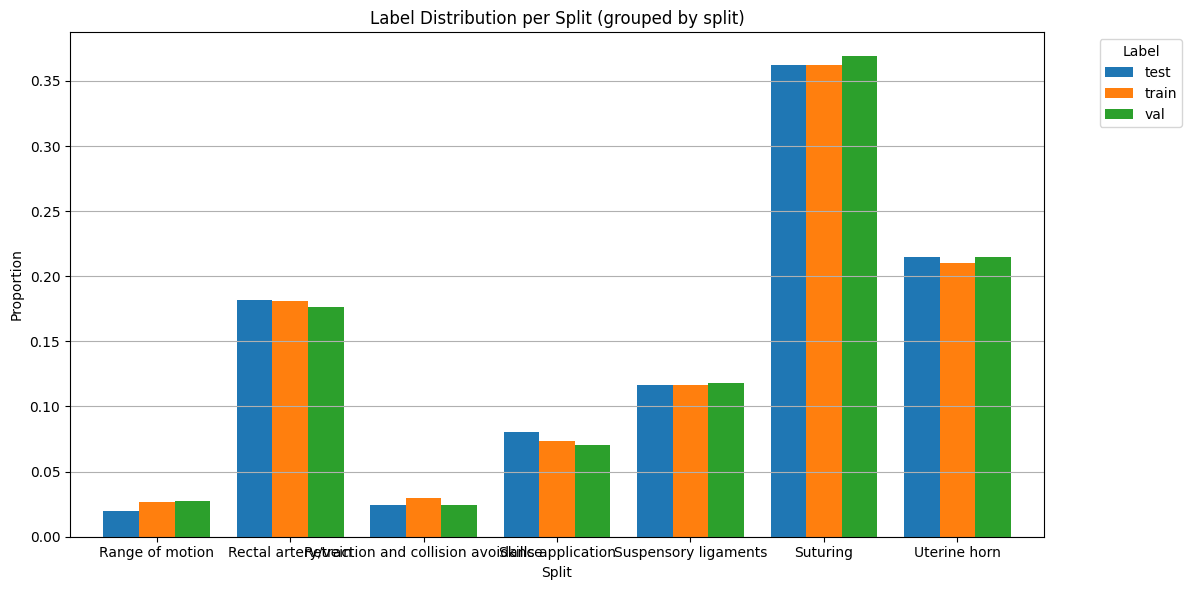

In [60]:
plot_label_distributions_grouped(summary)

In [ ]:
new_df.to_csv("../data/labels_index.csv", index=False)

In [ ]:
save_splits_to_json(new_df, "../data/splits.json")

In [98]:
new_df.groupby("split").size()/len(new_df)

split
test     0.094914
train    0.811917
val      0.093168
dtype: float64

### 15%

In [ ]:
df = pd.read_csv(LABELS_CSV_PATH)
df = df.dropna() 
new_df_15, summary_15 = prepare_balanced_split(df, n_trials=1000, test_frac=0.15, val_frac=0.15)
print(summary_15)

In [104]:
new_df_15.groupby("split").size()/len(new_df_15)
new_df_15.to_csv("../data/labels_index_15.csv", index=False)

In [105]:
save_splits_to_json(new_df_15, "../data/splits_15.json")

In [ ]:
df = pd.read_csv("../data/labels_index_15.csv")

frame_path      case  part  frame_time  \
0        case_000_video_part_001/frame_00001.jpg  case_000     1           1   
1        case_000_video_part_001/frame_00002.jpg  case_000     1           2   
2        case_000_video_part_001/frame_00003.jpg  case_000     1           3   
3        case_000_video_part_001/frame_00004.jpg  case_000     1           4   
4        case_000_video_part_001/frame_00005.jpg  case_000     1           5   
...                                          ...       ...   ...         ...   
2327829  case_154_video_part_002/frame_01796.jpg  case_154     2        1796   
2327830  case_154_video_part_002/frame_01797.jpg  case_154     2        1797   
2327831  case_154_video_part_002/frame_01798.jpg  case_154     2        1798   
2327832  case_154_video_part_002/frame_01799.jpg  case_154     2        1799   
2327833  case_154_video_part_002/frame_01800.jpg  case_154     2        1800   

             label  split  
0        unlabeled  train  
1        unlabeled  train  
2        unlabeled  train  
3        unlabeled  train  
4        unlabeled  train  
...            ...    ...  
2327829  unlabeled    val  
2327830  unlabeled    val  
2327831  unlabeled    val  
2327832  unlabeled    val  
2327833  unlabeled    val  

[2327834 rows x 6 columns]

In [45]:
split_summary = df['split'].value_counts().to_dict()
label_distribution = df[df['label'].notna() & (df['label'] != 'unlabeled')].groupby('split')['label'].value_counts(normalize=True).unstack().fillna(0).to_dict()

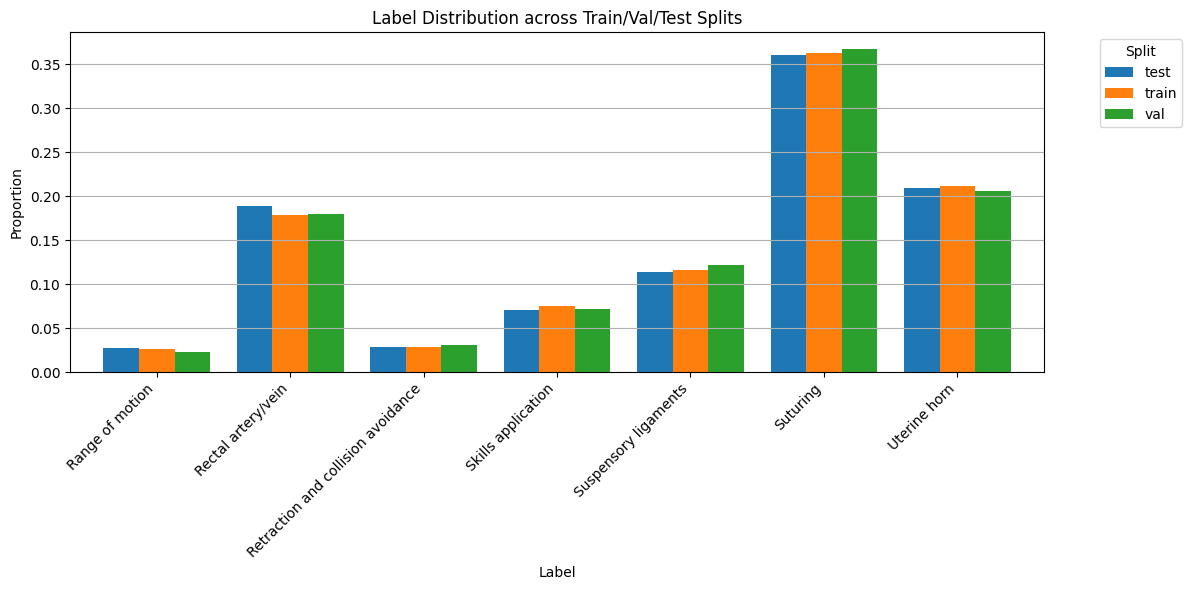

In [46]:
summary = {
    "split_summary": split_summary,
    "label_distribution_labeled_only": label_distribution
}

plot_label_distributions_grouped(summary)

### Comparison with a basic split

In [41]:
df = pd.read_csv("../data/labels_index_15.csv")
df['split'].value_counts()  

split
train    1648668
test      348290
val       330876
Name: count, dtype: int64

split
train    1674540
val       341430
test      311864
Name: count, dtype: int64


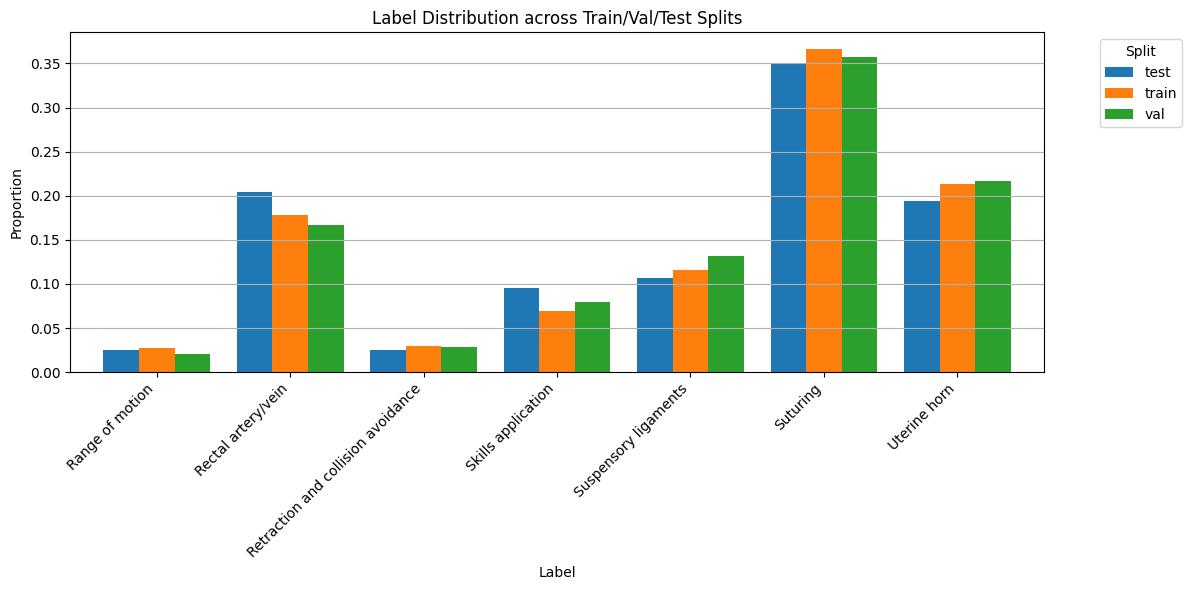

In [42]:
new_df_basic_split, summary_basic_split = prepare_basic_splits(df, 0.15, 0.15)
print(new_df_basic_split['split'].value_counts())
plot_label_distributions_grouped(summary_basic_split)

## Prepare smaller dataset for quick training

In [2]:
LABELS_CSV_PATH = "../data/labels.csv"
OUTPUT_CSV = "../data/labels_small_subset.csv"
FRAMES_DIR = "/Volumes/Samsung T7/surgvu24_extracted/"
SMALL_SUBSET_FRAMES_DIR = "/Volumes/Samsung T7/surgvu24_extracted_small_subset/"

In [ ]:
import pandas as pd
import random
from pathlib import Path
import shutil

IMAGE_ROOT = Path(FRAMES_DIR)
COPY_FRAMES_TO = Path(SMALL_SUBSET_FRAMES_DIR)
df = pd.read_csv(LABELS_CSV_PATH)

In [ ]:
import pandas as pd
from pathlib import Path

TARGET_SIZES_GB = [5, 10]    

for rel_path in df["frame_path"]:
    file_path = IMAGE_ROOT / rel_path
    if file_path.exists():
        file_size_bytes = file_path.stat().st_size
        file_size_mb = file_size_bytes / (1024 ** 2)
        print(f"Found file: {file_path}")
        print(f"File size: {file_size_mb:.2f} MB")

        for gb in TARGET_SIZES_GB:
            target_bytes = gb * (1024 ** 3)
            approx_needed = int(target_bytes / file_size_bytes)
            print(f"To reach ~{gb} GB, you'd need approximately {approx_needed} images of this size")

        break
else:
    print("❌ No valid image file found in the dataset.")
    exit()

# === Count how many (case, part) groups there are ===
num_groups = len(df.groupby(["case", "part"]))
print(f"Number of (case, part) groups: {num_groups}")

# === Calculate images per group for target sizes ===
for gb in TARGET_SIZES_GB:
    target_bytes = gb * (1024 ** 3)
    approx_needed = int(target_bytes / file_size_bytes)
    frames_per_group = max(1, approx_needed // num_groups)
    print(f"For ~{gb} GB, sample approximately {frames_per_group} images per (case, part) group.")

Found file: /Volumes/Samsung T7/surgvu24_extracted/case_000_video_part_001/frame_00001.jpg
File size: 0.11 MB
To reach ~5 GB, you'd need approximately 47828 images of this size
To reach ~10 GB, you'd need approximately 95656 images of this size
Number of (case, part) groups: 279
For ~5 GB, sample approximately 171 images per (case, part) group.
For ~10 GB, sample approximately 342 images per (case, part) group.


In [ ]:
N_FRAMES_PER_GROUP = 150
COPY_FRAMES_TO.mkdir(parents=True, exist_ok=True)

subset_rows = []

for (case, part), group in df.groupby(["case", "part"]):
    sampled = group.sample(n=min(N_FRAMES_PER_GROUP, len(group)), random_state=42)
    subset_rows.append(sampled)

subset_df = pd.concat(subset_rows)
subset_df

subset_df.to_csv(OUTPUT_CSV, index=False)
print(f"Saving small subset of frames to: {OUTPUT_CSV}")

for rel_path in subset_df["frame_path"]:
    src_path = IMAGE_ROOT / rel_path
    dest_path = COPY_FRAMES_TO / rel_path
    dest_path.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy2(src_path, dest_path)


Saving small subset of frames to: ../data/labels_small_subset.csv



Total frames: 41725
Labeled frames: 12746 (30.55%)
Unlabeled frames: 28979 (69.45%)


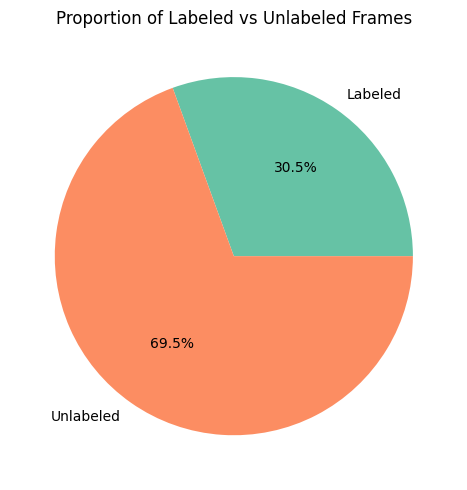

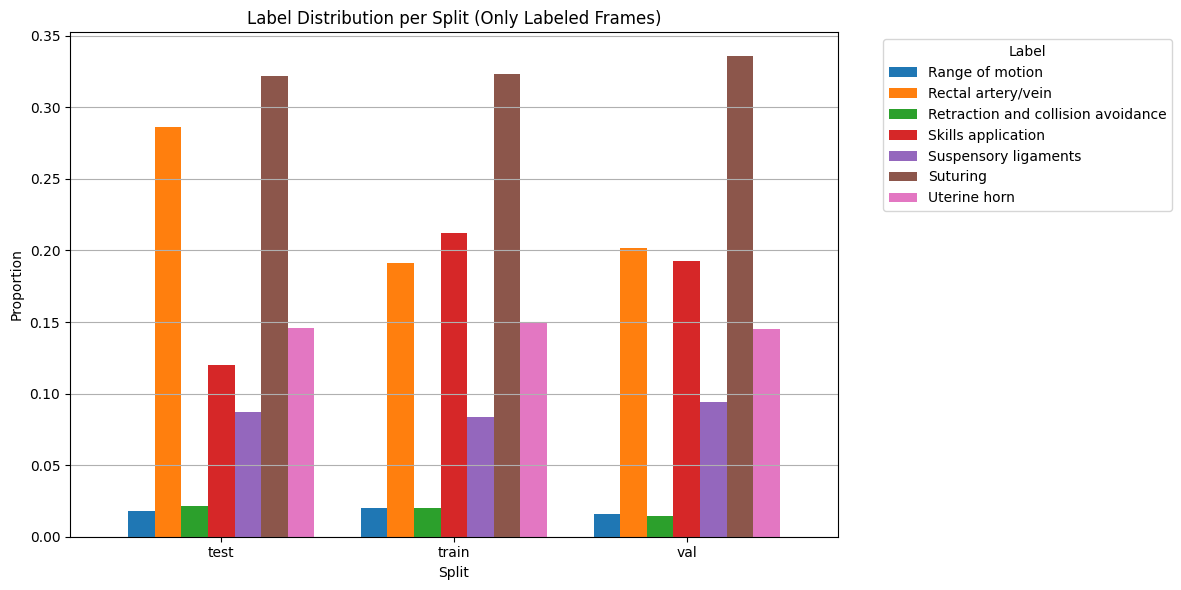

In [12]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path

subset_df_with_split = subset_df.copy()

with open("../data/splits_15.json", "r") as f:
    split_cases = json.load(f)

# === Assign 'split' column based on JSON ===
subset_df_with_split['split'] = 'unassigned'
for split_name, case_list in split_cases.items():
    subset_df_with_split.loc[subset_df_with_split['case'].isin(case_list), 'split'] = split_name

# === 1. Show number of labeled vs. unlabeled ===
label_counts = subset_df_with_split['label'].value_counts()
num_labeled = subset_df_with_split[subset_df_with_split['label'] != 'unlabeled'].shape[0]
num_unlabeled = subset_df_with_split[subset_df_with_split['label'] == 'unlabeled'].shape[0]
total = len(subset_df_with_split)

print(f"\nTotal frames: {total}")
print(f"Labeled frames: {num_labeled} ({num_labeled / total:.2%})")
print(f"Unlabeled frames: {num_unlabeled} ({num_unlabeled / total:.2%})")

# === 2. Pie chart for labeled vs. unlabeled ===
plt.figure(figsize=(5, 5))
plt.pie(
    [num_labeled, num_unlabeled],
    labels=["Labeled", "Unlabeled"],
    autopct="%1.1f%%",
    colors=["#66c2a5", "#fc8d62"]
)
plt.title("Proportion of Labeled vs Unlabeled Frames")
plt.tight_layout()
plt.show()

# === 3. Plot label distribution per split ===
labeled_only = subset_df_with_split[(subset_df_with_split['label'].notna()) & (subset_df_with_split['label'] != 'unlabeled')]
label_dist = labeled_only.groupby('split')['label'].value_counts(normalize=True).unstack().fillna(0)

# Plot grouped bar chart
ax = label_dist.plot(kind='bar', figsize=(12, 6), width=0.8)
ax.set_title("Label Distribution per Split (Only Labeled Frames)")
ax.set_ylabel("Proportion")
ax.set_xlabel("Split")
plt.xticks(rotation=0)
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Visualize the split distribution with Other label


Total frames: 2327834
Labeled frames: 744604 (31.99%)
Unlabeled frames: 1583230 (68.01%)


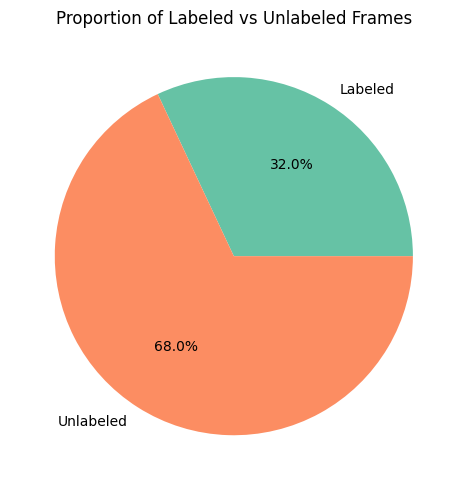

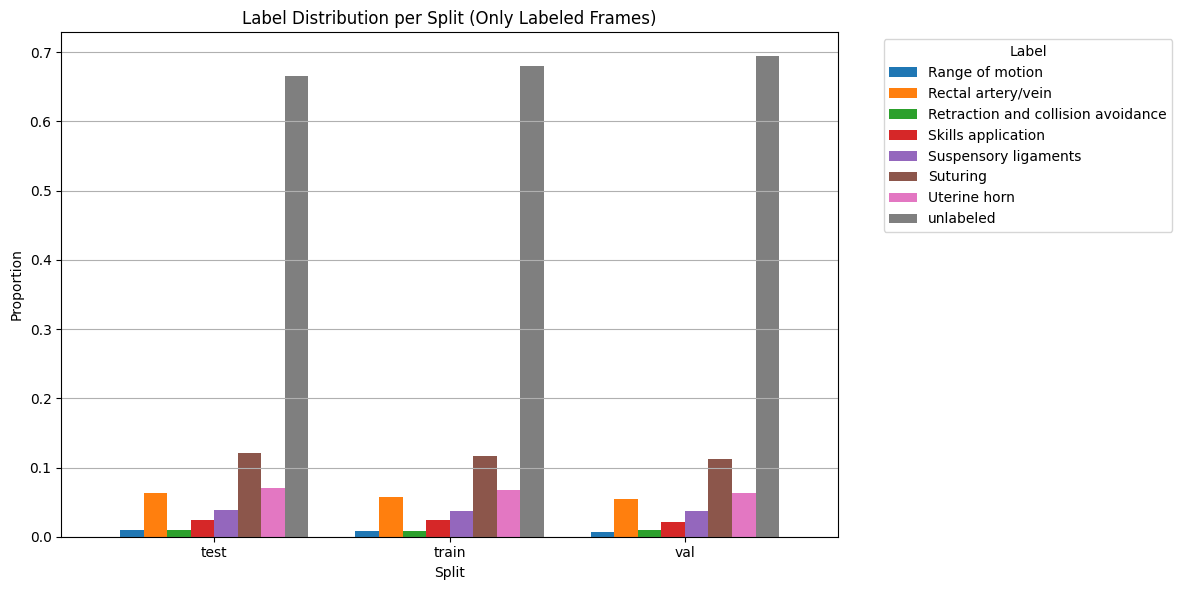

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path

df = pd.read_csv(LABELS_CSV_PATH)
assert not df.isna().sum().any()

with open("../data/splits_15.json", "r") as f:
    split_cases = json.load(f)

# === Assign 'split' column based on JSON ===
df['split'] = 'unassigned'
for split_name, case_list in split_cases.items():
    df.loc[df['case'].isin(case_list), 'split'] = split_name

# === 1. Show number of labeled vs. unlabeled ===
label_counts = df['label'].value_counts()
num_labeled = df[df['label'] != 'unlabeled'].shape[0]
num_unlabeled = df[df['label'] == 'unlabeled'].shape[0]
total = len(df)

print(f"\nTotal frames: {total}")
print(f"Labeled frames: {num_labeled} ({num_labeled / total:.2%})")
print(f"Unlabeled frames: {num_unlabeled} ({num_unlabeled / total:.2%})")

# === 2. Pie chart for labeled vs. unlabeled ===
plt.figure(figsize=(5, 5))
plt.pie(
    [num_labeled, num_unlabeled],
    labels=["Labeled", "Unlabeled"],
    autopct="%1.1f%%",
    colors=["#66c2a5", "#fc8d62"]
)
plt.title("Proportion of Labeled vs Unlabeled Frames")
plt.tight_layout()
plt.show()

# === 3. Plot label distribution per split ===
label_dist = df.groupby('split')['label'].value_counts(normalize=True).unstack().fillna(0)

# Plot grouped bar chart
ax = label_dist.plot(kind='bar', figsize=(12, 6), width=0.8)
ax.set_title("Label Distribution per Split (Only Labeled Frames)")
ax.set_ylabel("Proportion")
ax.set_xlabel("Split")
plt.xticks(rotation=0)
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Prepare labels in pickle format

```
separate files for each subset, each of format:
    dict of cases in subset:
        in each dict -> list of dict:
            each dict contains:
                - phase: phase number
                - unique_id: unique identifier for the frame in whole dataset based on number of case and test case + frame number
                - file_name    
        
```

In [25]:
label_to_id = {
    "unlabeled": 0,
    "Suturing": 1,
    "Uterine horn": 2,
    "Rectal artery/vein": 3,
    "Suspensory ligaments": 4,
    "Skills application": 5,
    "Retraction and collision avoidance": 6,
    "Range of motion": 7
}

id_to_label = {v: k for k, v in label_to_id.items()}

In [101]:
id_to_label

{0: 'unlabeled',
 1: 'Suturing',
 2: 'Uterine horn',
 3: 'Rectal artery/vein',
 4: 'Suspensory ligaments',
 5: 'Skills application',
 6: 'Retraction and collision avoidance',
 7: 'Range of motion'}

In [1]:
def generate_unique_id(case: str, part: int, frame_time: int) -> int:
    case_number = int(case.replace("case_", ""))
    return case_number * 10**7 + part * 10**6 + frame_time

In [ ]:
import pandas as pd
df = pd.read_csv("../data/labels_index_15.csv")

In [ ]:

import os
import pickle

for split in ['train', 'val', 'test']:
    output_dictionary = {}
    subset_per_split = df[df['split'] == split]
    
    for row in subset_per_split.itertuples():
        case = row.case
        part = row.part
        label = row.label
        frame_path = row.frame_path
    
        dir_name = os.path.dirname(frame_path)
        file_name = os.path.basename(frame_path)
        
        output_dictionary.setdefault(dir_name, []).append({
            "unique_id": generate_unique_id(case, part, row.frame_time),
            "case": case,
            "part": part,
            "phase": label_to_id[label],
            "file_name": file_name
        })
        
    output_file = f"../data/subset/labels/{split}.pkl"
    with open(output_file, 'wb') as f:
        pickle.dump(output_dictionary, f)


In [100]:
output_dictionary

{'case_009_video_part_001': [{'unique_id': 91000001,
   'case': 'case_009',
   'part': 1,
   'phase': 0,
   'file_name': 'frame_00001.jpg'},
  {'unique_id': 91000002,
   'case': 'case_009',
   'part': 1,
   'phase': 0,
   'file_name': 'frame_00002.jpg'},
  {'unique_id': 91000003,
   'case': 'case_009',
   'part': 1,
   'phase': 0,
   'file_name': 'frame_00003.jpg'},
  {'unique_id': 91000004,
   'case': 'case_009',
   'part': 1,
   'phase': 0,
   'file_name': 'frame_00004.jpg'},
  {'unique_id': 91000005,
   'case': 'case_009',
   'part': 1,
   'phase': 0,
   'file_name': 'frame_00005.jpg'},
  {'unique_id': 91000006,
   'case': 'case_009',
   'part': 1,
   'phase': 0,
   'file_name': 'frame_00006.jpg'},
  {'unique_id': 91000007,
   'case': 'case_009',
   'part': 1,
   'phase': 0,
   'file_name': 'frame_00007.jpg'},
  {'unique_id': 91000008,
   'case': 'case_009',
   'part': 1,
   'phase': 0,
   'file_name': 'frame_00008.jpg'},
  {'unique_id': 91000009,
   'case': 'case_009',
   'part': 1

In [ ]:
import json
with open("../data/splits_15.json", "r") as f:
    split_cases = json.load(f)

for split in ['train', 'val', 'test']:
    with open(f"../data/labels/{split}.pkl", 'rb') as f:
        split_pickle = pickle.load(f)
        cases_in_pickle = set( [ "_".join(case.split("_")[:2]) for case in split_pickle.keys()])
        assert set(split_cases[split]) == cases_in_pickle
